# Basal Mass Balance

For the portion of the ice base, which is at the pressure melting point, the basal melt rate for enthalpy is: 
$$
M_{\rm b} = \frac{ \left( F_{\rm b}  + \left( \mathbf{q}_{\rm geo}  - \mathbf{q}  \right) \cdot \mathbf{n} \right)}{(1-\omega)L\rho}
$$

where,
  - $M_b$ is the basal melt rate [m a$^{-1}$]
  - $\omega$ is the water content along the ice-bed interface [-]
  - $L$ is latent heat of fusion [J kg$^{-1}$]
  - $\rho$ is the density of ice  [kg m$^{3}$]
  - $F_{\rm b}$ is a frictional heat source [J a$^{-1}$ m$^{-2}$]
  - $\mathbf{q}$ is the basal enthalpy gradient [J a$^{-1}$ m$^{-2}$]
  - $\mathbf{q}_{\rm geo}$ is the geo thermal heat flux [J a$^{-1}$ m$^{-2}$]
  - $\mathbf{n}$ is the unit normal vector which points from the bedrock into the ice

In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt 
from thermal.constants import *
from thermal.gradient import calc_gradient
from thermal.utils import calc_conductivity
from thermal.derived_fields import calc_length

plt.rcParams['text.usetex'] = True

In [2]:
def calc_basal_gradient(src, field): 
    """Helper function to calculate basal gradient 
    
       returns: (2,nx) vector
    """
    # compute the gradient of the field 
    dFdz, dFdx = calc_gradient(src[field], src.Z, src.X)
    
    # extract the values along the base: 
    # NOTE: index 0 is bed, not -1 
    dFdz_b = dFdz[0,:]
    dFdx_b = dFdx[0,:]
    
    # pack the gradinent into a (2,nx) vector 
    grad_F_b = np.stack((dFdx_b, dFdz_b)) # [K m-1]
    
    return grad_F_b

def check_temperate(src, i): 
    """Check if ice at the i-th vertical coordinate is temperate
    """
    H_b = sub.enthalpy_h.isel(coord_2=i).compute()
    H_f = sub['phase change enthalpy'].isel(coord_2=i).compute()
    return (H_b >= H_f).values

def calc_heat_flux(src): 
    """ Calcuate the energy flux at the ice base
    
        Whether to use temp or enth gradient depends in the state
        of the ice base (i.e. if overlying temperate ice exists). 
        See Figure 5 from Aschwanden et al. 2012 
        
        returns: (2, nx) vector 
    """
    # calculate the basal ethalpy gradient (2,nx) 
    grad_E_b = calc_basal_gradient(src, 'enthalpy_h') # [J kg-1 m-1]
    # calculate the basal temperature gradient (2,nx) 
    grad_T_b = calc_basal_gradient(src, 'temperature') # [K m-1]

    # extract the temperature along the ice/bed interface 
    T_b = sub.temperature.isel(coord_2=0).values

    # heat capacity conducivity along the ice base [J K-1 m-1 a-1]
    k = calc_conductivity(T_b+273.15, 910.) * spy
    # temperate ice enthalpy diffusivity
    kappa = 3.295e3     #[kg m-1 a-1]

    # compute the heat flux vector 
    q_T = -k * grad_T_b   # [J a-1 m-2]
    # compute the heat flux vector 
    q_E = -kappa * grad_E_b   # [J a-1 m-2]
    
    # find where ice-base is temperate
    temp_base  = check_temperate(src, 0)
    # will return true for gridcells which are temperate, 
    # but have no overlying temperate ice
    no_temp_layer = ~temp_base & check_temperate(sub, 1)

    # return heat flux for all areas of bed (even those frozen), 
    # valid bmb areas will need to be masked later 
    q_ice = np.where(no_temp_layer, q_E, q_T)
    
    return q_ice

Let's load the reference glacier, and use it's steady-state resutls to figure out how significant the basal mass balance will be. 

In [3]:
src_fp = '/Volumes/thermal_ssd/crmpt12/thinned/crmpt12_dx_50_NT_30000_dt_0.1_MB_-0.37_OFF_Tma_-8.5_prog.zarr'
# lazy load the zarr file
src = xr.open_zarr(src_fp)
# drop the parameter dims for this purpose
src = src.squeeze()

Follow Greeve and Blatter (2009), we define the ice base as: 
$$
z_{\rm b} = b(x) - z = 0
$$
where $b(x)$ is the bed elevation and $z$ is the vertical coordinate. Note $b(x)$ is constant in time.

In order to calculate the basal mass balance, we first need thr unit normal vector, 
$$
\mathbf{n} = \frac{\nabla z_{\rm b}}{|\nabla z_{\rm b}|} = \frac{1}{N_{\rm b}} 
\begin{pmatrix}
-\frac{\partial z_{\rm b}}{\partial x} \\
1
\end{pmatrix}
$$
which points from bedrock into the ice. $N_{\rm b}$ is the gradient norm, 
$$
N_{\rm b} = |\nabla z_{\rm b}| = \left(1 + \left(\frac{\partial z_{\rm b}}{\partial x}\right)^2\right)^{1/2} . 
$$

Using the reference data, let's calculate $\mathbf{n}$. 

In [4]:
# x coordinate along the bed
x_b = src.X.isel(coord_2=0)
# bed elevation is NOT time dependent 
z_b = src.Z.isel(coord_2=0, t=-1)

# number of horizontal coordinates
nx = z_b.size

# calculate bed gradient in the x direction
dbdx = np.gradient(z_b, x_b)

# caclulate gardient norm 
N_b = (1 + dbdx**2)**(1/2)

# calculate the unit normal vector 
normal = (1/N_b) * np.stack((-dbdx , np.ones(nx)), 0)

Next we will create a geothermal heat flux vector $\mathbf{g_{\rm geo}}$: 

In [5]:
ghf = 0.055 * spy
# create a geothermal heat flux vector
q_geo = np.stack((np.zeros(nx) , ghf*np.ones(nx)), 0)

Next we will compute the enthalpy flux into the ice 
$$
\mathbf{q} = -\kappa \nabla H = -\kappa \begin{pmatrix} 
                                        \frac{\partial H}{\partial x} \\
                                        \frac{\partial H}{\partial z} 
                                        \end{pmatrix}
$$

In [6]:
# only interested in a single (the final) timestep for now
sub = src.isel(t=-1).compute()
# compute heat flux into the ice 
q_ice = calc_heat_flux(sub)
# find mask of temperate bed
mask = check_temperate(sub, 0)
# extract basal water content [-]
omega = sub['water content'].isel(coord_2=0)
# extract temperature along the ice-base
T_b = sub.temperature.isel(coord_2=0)
# find the glacier lenght [km] for plotting purposes 
L = float(calc_length(sub))

In [7]:
# calculate the basal mass balance! 
bmb = -(q_geo * normal - q_ice * normal).sum(axis=0) / ((1-omega)*L_heat*910) # [m a-1]

# bmb is only valid where bed is temperate 
bmb = np.where(~mask, 0, bmb)

In [10]:
max_bmb = float(bmb.min())*1000
print(f'print maximum basal mass balance is {max_bmb:.2f} mm')

print maximum basal mass balance is -6.06 mm


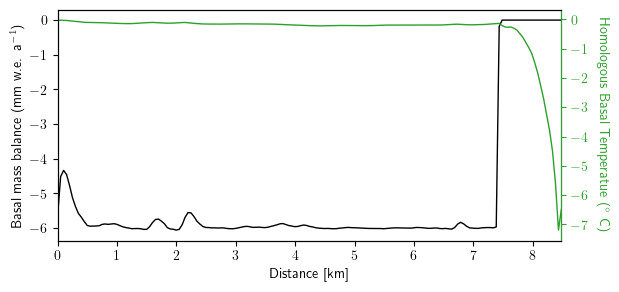

In [9]:
fig, ax1 = plt.subplots(figsize=(6.5, 3))
ax2 = ax1.twinx()

ax1.plot(x_b[::-1]/1e3, bmb*1e3, color='k', lw=1.0, label='Basal Mass Balance')
ax2.plot(x_b[::-1]/1e3, T_b, color='tab:green', lw=1.0, label='Basal Temperature')


# ax1.legend(loc='center left')
# ax2.legend(loc='lower left', bbox_to_anchor=(0.001, 0.525))

ax1.set_ylabel('Basal mass balance (mm w.e. a$^{-1}$)')
ax2.set_ylabel('Homologous Basal Temperatue ($^\circ$ C)',
               rotation=270, labelpad=15)

ax2.yaxis.label.set_color('tab:green')
ax2.tick_params(axis='y', colors='tab:green')
ax2.spines['right'].set_color('tab:green')
ax1.set_xlabel('Distance [km]')

ax1.set_xlim(0, L)

fig.savefig('../figs/crmpt12/ref_glacier_BMB.pdf')
fig.savefig('../figs/crmpt12/ref_glacier_BMB.png', dpi=600)

In [ ]:
bmb = (q_geo * normal + kappa*grad_T_b * normal ).sum(axis=0) / (H*910)
bmb = xr.where(omega >= 1e-3, bmb, 0.0)

smb = src['mass balance'].isel(t=-1).compute()

In [ ]:
max_bmb = float(bmb.min())*100

print(f'print maximum basal mass balance is {max_bmb:.2f} cm')

In [ ]:
max_bmb/100

In [ ]:
plt.pcolormesh(sub.X[:,::-1], 
               sub.Z, 
               dTdz, 
               vmin=-0.05, vmax=0.05, 
               shading='gouraud')

plt.colorbar()

In [ ]:
dTdz.max()

In [ ]:
M_s = src['mass balance'].isel(t=-1).compute()

In [ ]:
def vertical_gradient(ds): 
    return xr.apply_ufunc(np.gradient,
                          ds.temperature,
                          ds.Z,
                          input_core_dims=[["coord_2"], ["coord_2"]],
                          output_core_dims=[["coord_2"]],
                          kwargs={"axis": -1})
    
full = sub.groupby('coord_1').apply(vertical_gradient)

In [ ]:
x = np.linspace(0,1,11)**2

In [ ]:
sin = np.sin(x)
cos = np.cos(x)

In [ ]:
(sin[1] - sin[0]) / (x[1] - x[0])

In [ ]:
def calc_weights(k, xbar, x, n): 

    A = np.ones((n,n))
    
    xrow = x[:] - xbar
    
    for i in range(2,n+1): 
        A[i-1] = xrow ** (i-1) / factorial(i-1)

    b = np.zeros((n))
    b[k] = 1
    
    c = np.linalg.solve(A,b)
    
    return c

In [ ]:
for n in range(2, 6): 
    # calculate weights
    c = calc_weights(1, x[0], x[:n], n)
    # calculate the finite difference approximation
    x_prime = (c * sin[:n]).sum()
    # second order graident using numpy
    gradient = np.gradient(sin,x,edge_order=2)
    
    print(f'{cos[0] - x_prime:.3e}, {gradient[0] - x_prime:.3e}')

In [ ]:
c = np.linalg.solve(A,b)

In [ ]:
calc_weights(1, x[1], x[0:3], 3) * 0.1

In [ ]:
np.diag(np.ones(nx -1), k=-1) + np.diag(np.ones(nx -1), k=1)  

In [ ]:
z = sub.Z.values
T = sub.temperature.values

nx = src.coord_1.size
nz = src.coord_2.size

In [ ]:
print(z.shape)

In [ ]:
coefs = np.zeros((nz,nz,nx))

for j in range(nx): 

    coefs[0,  0:3, j] = calc_weights(1, z[0,j],  z[0:3, j].flatten(), 3)
    coefs[-1, -3:, j] = calc_weights(1, z[-1,j], z[-3:, j].flatten(), 3)

    for i in range(1,nz-1): 
        coefs[i, i-1:i+2, j] = calc_weights(1, z[i,j], z[i-1:i+2, j].flatten(), 3)

    

In [ ]:
np.gradient(T[:,j].flatten(), z[:,j] .flatten(), edge_order=2)

In [ ]:
coefs[:,:,j] @ T[:,j] 

In [ ]:
einsum = np.einsum('ijk, jk -> ik', coefs, T)

In [ ]:
np_grad = np.zeros_like(T)

for j in range(nx): 
    np_grad[:, j] = np.gradient(T[:,j], z[:,j], edge_order=2)

In [ ]:
np.linalg.norm(np_grad - einsum)

In [ ]:
from sympy import finite_diff_weights, S

In [ ]:
finite_diff_weights(1, z[i-1:i+2, j].flatten(), z[i,j])[1][-1]

In [ ]:
coefs[i, i-1:i+2, j]

In [ ]:
from sympy import finite_diff_weights, symbols

In [ ]:
x, h_ip1, h_im1 = symbols('x h_{i+1} h_{i-1}')

In [ ]:
x_list = [

In [ ]:
from __future__ import print_function
from sympy import *
init_printing() 
#https://docs.sympy.org/latest/explanation/special_topics/finite_diff_derivatives.html?highlight=finite+difference
x, x0, h_im1, h_ip1 = symbols('x, x_0, h_s, h_d')
Fi, Fip1, Fip2 = symbols('f(x_{i}), f(x_{i}-h_s), f(x_{i}+h_d)')
n = 3 # there are the coefficients c_0=Fi, c_1=dF/dx, c_2=d**2F/dx**2
c = symbols('c:3')
def P(x, x0, c, n):
    return sum( ((1/factorial(i))*c[i] * (x-x0)**i for i in range(n)) )

In [ ]:
R = Matrix([[Fi], [Fip1], [Fip2]])

In [ ]:
m11 = P(x0 , x0, c, n).diff(c[0])
m12 = P(x0 , x0, c, n).diff(c[1])
m13 = P(x0 , x0, c, n).diff(c[2])

In [ ]:
m21 = P(x0-h_im1, x0, c, n).diff(c[0])
m22 = P(x0-h_im1, x0, c, n).diff(c[1])
m23 = P(x0-h_im1, x0, c, n).diff(c[2])

In [ ]:
m31 = P(x0+h_ip1, x0, c, n).diff(c[0])
m32 = P(x0+h_ip1, x0, c, n).diff(c[1])
m33 = P(x0+h_ip1, x0, c, n).diff(c[2])

In [ ]:
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

In [ ]:
X =  M.inv() * R

In [ ]:
together(X[1])

In [ ]:
from __future__ import print_function
from sympy import *
init_printing() 

x, x0, h_im1, h_ip1 = symbols('x, x_0, h_s, h_d')
Fi, Fip1, Fip2 = symbols('F_{i}, F_{i-1}, F_{i-2}')
n = 3 # there are the coefficients c_0=Fi, c_1=dF/dx, c_2=d**2F/dx**2
c = symbols('c:3')
def P(x, x0, c, n):
    return sum( ((1/factorial(i))*c[i] * (x-x0)**i for i in range(n)) )

In [ ]:
R = Matrix([[Fi], [Fip1], [Fip2]])

In [ ]:
m11 = P(x0 , x0, c, n).diff(c[0])
m12 = P(x0 , x0, c, n).diff(c[1])
m13 = P(x0 , x0, c, n).diff(c[2])

In [ ]:
m21 = P(x0-h_im1, x0, c, n).diff(c[0])
m22 = P(x0-h_im1, x0, c, n).diff(c[1])
m23 = P(x0-h_im1, x0, c, n).diff(c[2])

In [ ]:
m31 = P(x0-h_ip1, x0, c, n).diff(c[0])
m32 = P(x0-h_ip1, x0, c, n).diff(c[1])
m33 = P(x0-h_ip1, x0, c, n).diff(c[2])

In [ ]:
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

In [ ]:
X =  M.inv() * R

In [ ]:
together(X[1])

In [ ]:
# euclidian distance along axis 0 at x_j
dist = z[1:,j] - z[:-1,j]

# get gridcell spacing at aread of interest
hd = dist[1:, None]
hs = dist[:-1,None]

# super diagonal f(x+h_{i+1})
# main diagonal  f(x)
# sub diagonal   f(x-h_{i-1})
interior = \
np.eye(nz-2, nz, 2)  * hs**2 + \
np.eye(nz-2, nz, 1)  * (hd**2 - hs**2)  + \
-np.eye(nz-2, nz, 0) * hd**2

# scale the coefficent matrix by the proper denominatior
interior /= hs*hd*(hs+hd)


# weights = np.zeros((nz,nz))
# # dump the interior matrix, i.e. centered finite difference 
# weights[1:-1, :] = interior
# # use a first order difference along the boundaries
# weights[0,  0:2] = [-1, 1] / dist[0]
# weights[-1, -2:] = [-1, 1] / dist[-1]

# np.linalg.norm((weights @ T[:,j]) - np.gradient(T[:,j], z[:,j]))

In [ ]:
j=100

In [ ]:
%%timeit 1000

# create the template interior stencil array (nz-2, nz)
# i.e. it's the interior stencil for a single x coordinate
sup  =  np.eye(nz-2, nz, 2)
main =  np.eye(nz-2, nz, 1)
sub  = -np.eye(nz-2, nz, 0) 
# ref: https://stackoverflow.com/a/55513250/10221482

# euclidian distance for every x coordinate
dist = np.diff(z, axis=0)

# get gridcell spacing at aread of interest
hd = dist[ 1:, :]
hs = dist[:-1, :]

# get the denomaintor 
denom = (hs*hd*(hs+hd))

# broadcast template stencil array (nz-2, nz)gridcellspacing array(nz-1, nz) to be (nz-2, nz, nx) 
# where: 
#      i -- nz-2
#      j -- nx
#      k -- nz
interior = np.einsum('ij,ik->ikj', hs**2/denom, sup)  + \
           np.einsum('ij,ik->ikj', (hd**2 - hs**2)/denom, main) +\
           np.einsum('ij,ik->ikj', hd**2/denom, sub)

# create the full coefs vector (nz, nz, nx),
# i.e. a (nz, nz) matrix for every x gridpoint 
# which is empty for now 
weights = np.zeros((nz,nz,nx))
# dump the interior matrix, i.e. centered finite difference 
weights[1:-1, :, :] = interior

# use a first order difference along the boundaries
weights[0,  0:2, :] = (np.array([[-1], [1]]) * np.ones((1,nx))) / dist[0]
weights[-1, -2:, :] = (np.array([[-1], [1]]) * np.ones((1,nx))) / dist[0]

# compute the gradient!!
np.einsum('ijk, jk -> ik', weights, T)

# np_grad = np.zeros_like(T)

# for j in range(nx): 
#     np_grad[:, j] = np.gradient(T[:,j], z[:,j])
    
# np.linalg.norm(np_grad - np.einsum('ijk, jk -> ik', weights, T))

In [ ]:
def calc_coefs(shape, axis, dist, edge_order=1): 
    """
    input: 
        z (nz, nx) : 
    
    output: 
        c (nz, nz, nx): i.e. a (nz,nz) coefficent matrix for every nx point in the domain
        
    input a two dimmesion Z coordinate array
    
    used to calculate the gridcell spacing, and with those spacing fill in the appropriate finite difference operator matrix 
    """
    # unpack the shape tuple
    nz, nx = shape
    
    # determine the size of the interior stencil matrix 
    if axis==0: 
        # i.e. taking gradient along vertical (z) coordinate
        int_m = nz-2
        int_n = nz
        # get the vertical gridcell spacing 
        hd = dist[ 1:, :]  # + an element, vertically 
        hs = dist[:-1, :]  # - an element, vertically 
        # summation indexes for doing array broadcasting 
        einsum_path = 'ij,ik->ikj'
    elif axis==1: 
        # i.e. taking gradient along horizontal (x) coordinate
        int_m = nx-2
        int_n = nx
        # get the vertical gridcell spacing 
        hd = dist[:, 1 :]  # + an element, horizontally 
        hs = dist[:, :-1]  # - an element, horizontally
        # summation indexes for doing array broadcasting 
        einsum_path = 'ij,jk->ijk'

    # create the template interior stencil array (nz-2, nz)
    # i.e. it's the interior stencil for a single x coordinate
    sup  =  np.eye(int_m, int_n, 2)
    main =  np.eye(int_m, int_n, 1)
    sub  = -np.eye(int_m, int_n, 0) 
    # ref: https://stackoverflow.com/a/55513250/10221482

    # get the denomaintor 
    denom = (hs*hd*(hs+hd))

    # broadcast template interior stencil arrays (nz-2, nz)  and 
    # gridcellspacing array(nz-2, nx) to be (nz-2, nz, nx) 
    # where: 
    #      i -- nz-2
    #      j -- nx
    #      k -- nz
    interior = np.einsum(einsum_path, hs**2/denom, sup)  + \
               np.einsum(einsum_path, (hd**2 - hs**2)/denom, main) +\
               np.einsum(einsum_path, hd**2/denom, sub)

    # create the full coefs vector (nz, nz, nx),
    # i.e. a (nz, nz) matrix for every x gridpoint 
    # which is empty for now 
    if axis==0: 
        coefs = np.zeros((nz,nz,nx))
        # dump the interior matrix, i.e. centered finite difference 
        coefs[1:-1, :, :] = interior

        # use a first order difference along the boundaries
        coefs[0,  0:2, :] = (np.array([[-1], [1]]) * np.ones((1,nx))) / dist[0,  :]
        coefs[-1, -2:, :] = (np.array([[-1], [1]]) * np.ones((1,nx))) / dist[-1, :]
    
    elif axis==1: 
        coefs = np.zeros((nz,nx,nx))
        # dump the interior matrix, i.e. centered finite difference 
        coefs[:,1:-1,:] = interior
        
        # use a first order difference along the boundaries
        coefs[:, 0,  0:2] = (np.array([[-1, 1]]) * np.ones((nz,1))) / dist[:,   0:1]
        coefs[:, -1, -2:] = (np.array([[-1, 1]]) * np.ones((nz,1))) / dist[:, -2:-1]
    
    return coefs

In [ ]:
sub = src[['temperature', 'Z', 'X']].isel(t=-1).compute()

z = sub.Z.values
x = sub.X.values
T = sub.temperature.values

nx = src.coord_1.size
nz = src.coord_2.size

In [ ]:
# euclidian distance for every x coordinate
# dist = np.diff(z, axis=0)
dist = np.diff(x, axis=1)
# dist[:,:] = 50

# get gridcell spacing at aread of interest
# hd = dist[ 1:, :]
# hs = dist[:-1, :]
# hd = dist[:,  1:]
# hs = dist[:, :-1]

coefs = calc_coefs((nz,nx), 1, dist)

# compute the gradient!!

# vertical gradient 
# grad_z = np.einsum('ijk, jk -> ik', coefs, T)

# horizontal gradient 
grad_x = np.einsum('ijk, ik -> ij', coefs, T)


np_grad = np.zeros_like(T)

for j in range(nz): 
    np_grad[j, :] = np.gradient(T[j,:], x[j,:], edge_order=1)
    
np.linalg.norm(np_grad - grad_x)

In [ ]:
if np.all(hs) & np.all(hd): 
    print('constant horizontal gridcell spacing')

In [ ]:
def gradient(da, Z, X): 
    """ Take the gradient of a multidimensional scalar field. 
        
        Note: this function does not support time dependent data. 
              To calculate the gradient as a fucntion of time first group by 'time' 
              then apply this function over:
              ```
              da.groupby('t').apply(graient)
              ```
        where: 

            da (nz, nx) --> is the multidimensional dataarray to take the gradient of 
            X  (nz, nx) --> is the x coordinate array, defined at every node
            Z  (nz, nx) --> is the z coordinate array, defined ar every node
    
    """
    assert X.shape == Z.shape
    
    nz, nx = Z.shape
    
    # vertical gridceel spacing (nz-1, nx)
    dz = np.diff(Z, axis=0)
    # finite difference coefficent matrix (nz, nz, nx)
    coefs = calc_coefs((nz,nx), 0, dz)
    # compute the gradient!!
    grad_z = np.einsum('ijk, jk -> ik', coefs, da)

    # horizontal gridcell spacing (nz, nx-1)
    dx = np.diff(X, axis=1)
    # finite difference coefficent matrix (nz, nx, nx)
    coefs = calc_coefs((nz,nx), 1, dx)
    # compute the gradient!!
    grad_x = np.einsum('ijk, ik -> ij', coefs, da)
    
    
    return grad_z, grad_x

In [ ]:
sub = src[['temperature', 'Z', 'X']].isel(t=-1).compute()

z = sub.Z.values
x = sub.X.values
T = sub.temperature.values

nx = src.coord_1.size
nz = src.coord_2.size


In [ ]:
%%timeit

dTdz, dTdx = gradient(T, z, x)

In [ ]:
%%timeit

dTdz_np = np.zeros_like(T)
dTdx_np = np.zeros_like(T)

# for each horizontal column, compute the vertical temperature gradient
for i in range(nz): 
    dTdx_np[i,:] = np.gradient(T[i,:], x[i,:])
    
# for each vertical layer, compute the horizontal temperature gradient
for j in range(nx): 
    dTdz_np[:,j] = np.gradient(T[:,j], z[:,j])

In [ ]:
np.linalg.norm(dTdx - dTdx_np)

In [ ]:
dTdz_np.shape

In [ ]:
gradient(T, x, z)